In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # graphs
import matplotlib.pyplot as plt # plot visualizations
from sklearn.metrics import f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Github Link :https://github.com/colites/NLP-Disaster-Tweets 

The challenge problem for this project is to be able to classify disaster tweets has real or fake. The dataset has tweets that have been labeled as real or fake and the model that is going to be created must be able to effectively distinguish between both. The model that is going to be used during this project will be the RNN architecture models, such as the simpleRNN and the LSTM architectures. Their performance will be compared and the best one will be the final model. 

This challenge problem requires NLP knowledge, which stands for natural language processing. Natural language processing basically is a field where machines process human language and attempt to manipulate or interpret it. This project will require NLP because the text must be processed and understood to be able to effectively classify the tweets as being real or fake. To do this, the model must be able to learn the underlying pattern in the sequences of texts, in this case the RNN will be the model that will be doing NLP to classify the tweets.

To begin this project, there must be data cleaning, which means duplicates must be dropped and empty values must be dropped from the dataframes. This is to make the data more reliable and the models train with less performance issues. Afterwards, basic EDA must be done.

In [50]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print(train_data.shape)
train_data.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [51]:
train_data['word_count']=train_data['text'].apply(lambda x: len(x.split()))
train_data.head()

,id,keyword,location,text,target,word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16


110


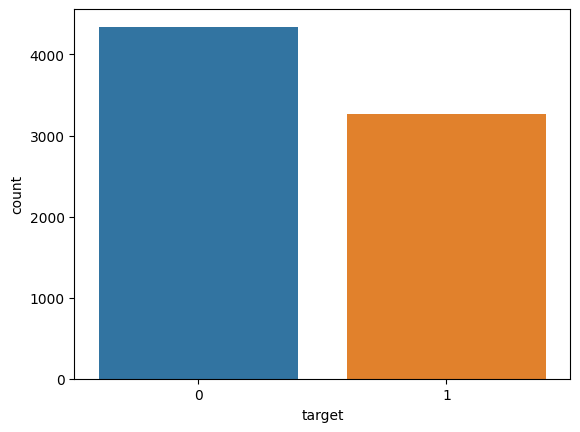

In [52]:
#find the number of duplicates in the training data
duplicates = train_data['text'].duplicated().sum()
print(duplicates)

value_counts_df = train_data['target'].value_counts().reset_index()
value_counts_df.columns = ['target', 'count']

ax = sns.barplot(x='target', y='count', data=value_counts_df)

In [53]:
missing_values_count = train_data.isnull().sum()
print(f' The number of missing values is :{missing_values_count}')

 The number of missing values is :id               0
keyword         61
location      2533
text             0
target           0
word_count       0
dtype: int64


We will drop the keyword and location columns because they contain empty values and we are not going to be using those columns, so dropping them will solve the problem of null values.

In [54]:
train_data.drop(['keyword', 'location'], axis=1, inplace=True)
train_data.head()

,id,text,target,word_count
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,8
4,7,Just got sent this photo from Ruby #Alaska as ...,1,16


0


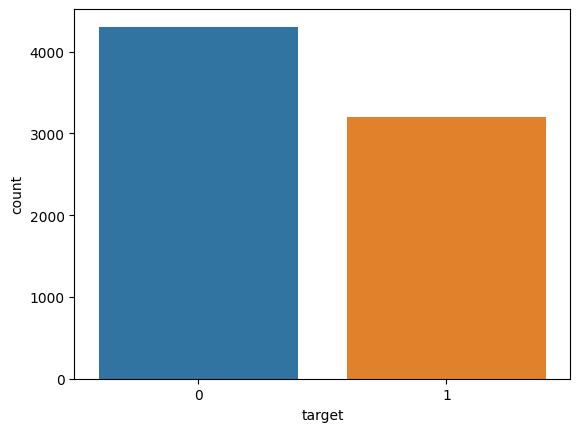

In [55]:
train_data = train_data.drop_duplicates(subset='text')
duplicates = train_data['text'].duplicated().sum()
print(duplicates)

value_counts_df = train_data['target'].value_counts().reset_index()
value_counts_df.columns = ['target', 'count']

ax = sns.barplot(x='target', y='count', data=value_counts_df)

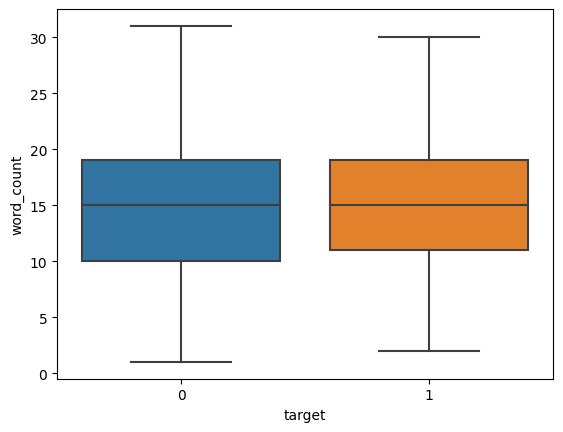

In [56]:
## a plot to get the ranges for word count in the text data
ax2 = sns.boxplot(x='target', y='word_count', data=train_data)

In [57]:
train_labels = train_data['target']
train_features = train_data['text']

test_features = test_data['text']

print("test features shape: ", test_features.shape)
print("test features type: ", test_features.dtype)
print("train features shape: ", train_features.shape)
print("train labels shape: ", train_labels.shape)

test features shape:  (3263,)
test features type:  object
train features shape:  (7503,)
train labels shape:  (7503,)


In [58]:
## This snippet tokenizes the texts by creating a dictionary of a word to an numerical id. Then this is turned into a sequence of integers. The RNN structure only takes in a certain length sequence, so a length is set
## and anything that is shorter is padded with 0's while anything longer has the extra integers removed.
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_features) 

# Convert the text to sequences of integers
sequences = tokenizer.texts_to_sequences(train_features)
test_sequences = tokenizer.texts_to_sequences(test_features)

padded_sequences = pad_sequences(sequences, maxlen=100, padding='post')
padded_test_sequences = pad_sequences(test_sequences, maxlen=100, padding='post')

In [59]:
## Modularized function to graph a metric based on the fitted model's history
def plot_metrics_graph(metric, x_label, title):
    plt.plot(metric)
    plt.title(title)
    plt.ylabel(x_label)
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()
    
## Function to create a submission csv
def submit_csv(name, test_pred):
    submission = test_data.rename(columns={'text': 'target'})
    if 'keyword' in submission.columns and 'location' in submission.columns:
        submission.drop(['keyword', 'location'], axis=1, inplace=True)
    submission['target'] = test_pred
    submission.to_csv(name, index=False)

The first architecture I am going to explore will be the RNN architecture. This is the simplest of the sequential neural network models, with more advanced models like LSTM being used later for comparison.

The first layer is an embedding layer that transforms each token into a dense vector. This layer also decides the characteristics of the sequence vectors that will be analyzed by the RNN layer. For the first architecture, the vector dimensions will be 128 and the length of the sequence vectors will all be 100. The sequences were padded during preprocessing previously to be of length 100 and the output vectors will be the same length.

The RNN layer is made up of 64 neurons. 64 neurons were chosen for this RNN architecture because it is a commonly used number of neurons due to it being a moderate position, with the choice to be able to reduce the number of neurons if there is overfitting or increase the number of neurons if there is underfitting. The simpleRNN layer takes care of the hidden state updates for all the RNN Neurons in the layer. There will be 1 RNN layer to be able to see the effects of neurons in a layer, but it is possible to have multiple RNN layers. Having 1 layer may result in underfitting, but this first architecture will test the number of neurons in a layer more than the number of layers.

The last dense layer is the classification layer with a sigmoid activation. This is the layer that actually returns the binary probability. This layer has one neuron because this is a binary classification task and it gets the information from the RNN layer. The probability of the sequence is calculated by the sigmoid activation function, which outputs a probability score between 0 and 1. This score can then used to classify to one of the target labels. 

The procedure to optimize hyperparameters is to just start out with common defaults and then change directions based on how the model does. For example, if a model overfits then I would tune the hyperparameters to regularize more or tune the hyperparameters to reduce the complexity of the model and therefore reduce the overfitting. If there is underfitting, when the model does not get good training metrics, then more complexity by tuning the hyperparameters will happen. In this case, one example is when I tuned neurons and reduced or increased them based on how well the models performed. 

In [60]:
def RNN_simple():
    model = Sequential([
                Embedding(input_dim=10000 , output_dim=128, input_length=100),
                SimpleRNN(units=64, return_sequences=False),
                Dense(units=1, activation='sigmoid')
            ])
    
    return model

In [61]:
model_simple_RNN = RNN_simple()
model_simple_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

history_simple_RNN = model_simple_RNN.fit(padded_sequences, train_labels, epochs=10)

Epoch 1/10
235/235 [==============================] - 9s 30ms/step - loss: 0.6837 - accuracy: 0.5614 - precision: 0.4579 - recall: 0.1582
Epoch 2/10
235/235 [==============================] - 7s 29ms/step - loss: 0.6362 - accuracy: 0.6376 - precision: 0.6105 - recall: 0.4137
Epoch 3/10
235/235 [==============================] - 7s 31ms/step - loss: 0.5123 - accuracy: 0.7792 - precision: 0.7874 - recall: 0.6601
Epoch 4/10
235/235 [==============================] - 7s 29ms/step - loss: 0.4437 - accuracy: 0.8178 - precision: 0.8453 - recall: 0.7008
Epoch 5/10
235/235 [==============================] - 7s 29ms/step - loss: 0.3864 - accuracy: 0.8478 - precision: 0.8530 - recall: 0.7767
Epoch 6/10
235/235 [==============================] - 7s 31ms/step - loss: 0.3380 - accuracy: 0.8738 - precision: 0.8877 - recall: 0.8058
Epoch 7/10
235/235 [==============================] - 7s 30ms/step - loss: 0.4963 - accuracy: 0.7394 - precision: 0.7209 - recall: 0.6341
Epoch 8/10
235/235 [==============

The competition is being evaluated using F1-score, so the F1-score must be calculated to effectively measure how the model is doing for the competition

The F1-score is (2 * Precision * Recall)/ (Precision + Recall). The F1-score basically represents a balance between precision and recall. Since Keras does not have a F1-score function that can be measured each epoch, then it must be calculated manually after the model is fitted.

This means that the Precision and Recall must be kept track of to be able to do the final F1-score calculation. The accuracy will also be tracked as well as the loss. 

In [62]:
## function that does an prediction using the chosen model architecture
def model_predict(model, padded_sequences):
    ## Model outputs probabilities for the True label, must be made into binary predictions
    y_pred_prob = model.predict(padded_sequences)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    y_pred = y_pred.flatten()
    
    return y_pred

235/235 [==============================] - 2s 7ms/step
this is the final f1-score for the train set: 0.7992508087859697


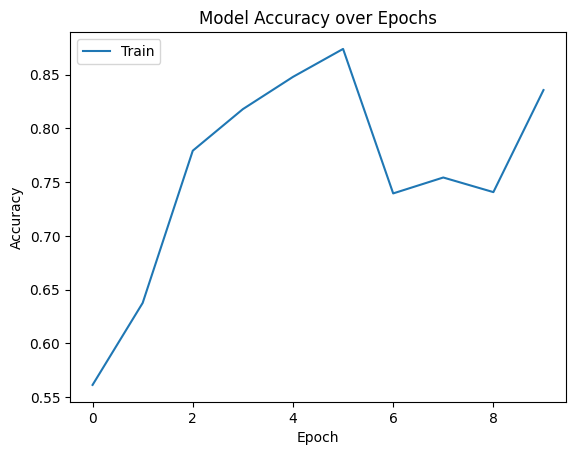

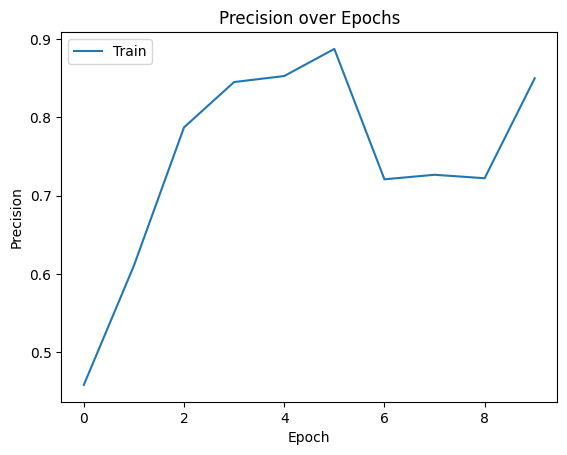

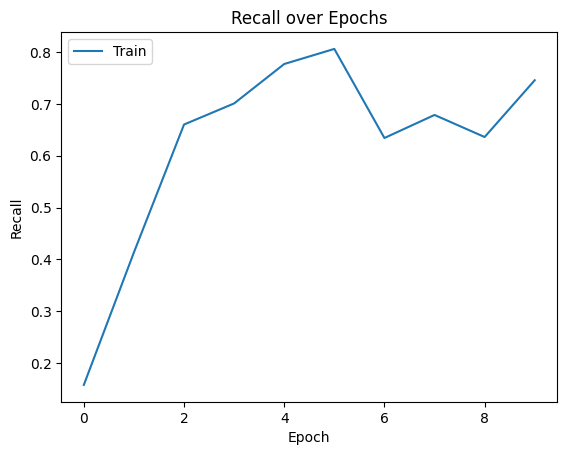

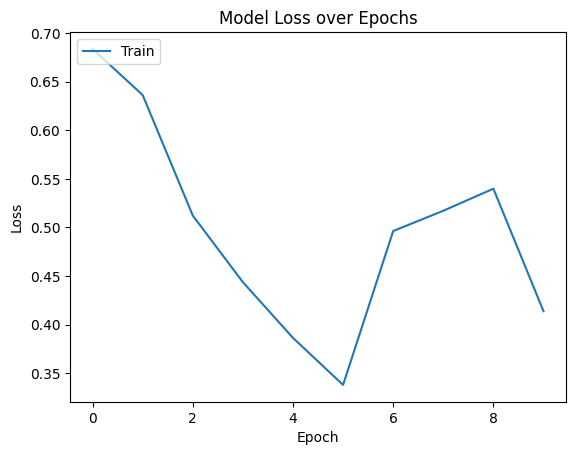

In [63]:
y_pred = model_predict(model_simple_RNN, padded_sequences)
f1 = f1_score(train_labels, y_pred)
print(f'this is the final f1-score for the train set: {f1}')
plot_metrics_graph(history_simple_RNN.history['accuracy'], 'Accuracy', 'Model Accuracy over Epochs')
plot_metrics_graph(history_simple_RNN.history['precision'], 'Precision', 'Precision over Epochs')
plot_metrics_graph(history_simple_RNN.history['recall'], 'Recall', 'Recall over Epochs')
plot_metrics_graph(history_simple_RNN.history['loss'], 'Loss', 'Model Loss over Epochs')

In [64]:
y_pred = model_predict(model_simple_RNN, padded_test_sequences)

102/102 [==============================] - 1s 7ms/step


In [65]:
submit_csv('simple.csv', y_pred)

The One layer RNN does very well depending on the initialization. The precision and recall heavily depend on initial weights, since fitting the one layer RNN multiple times led to some 0.0  training f1 scores. some training 0.91 f1 scores, and the 0.74 f1 score that was the final fitting of the model. It seems that in the final fitting of the simple RNN architecture with one layer, the precision and recall were maximized in teh 6th epoch. If the models continue to maximize at lower epochs, the training epochs may be reduced to prevent reduction of precision and recall. The final test f1 score was 0.654 for the first simple model

We can try out a two-layer RNN to see whether the f1-score will increase slightly, due to possible capturing more complex patterns in the data. There is a strong possibility that the data from the two-layer RNN will overfit due to the model becoming too complex and learning the training dataset, since the one-layer model already did very well occasionally in the training dataset. There is also a possibility that instead of overfitting and getting a better score for the training set, the two-layer model may get a worse f1-score due to having more noise be registered by the model due to its increased complexity. The model may try to learn complex details that are ultimately unhelpful and detrimental to classifing, which would decrease the f1-score. 

Since the two-layer RNN is more complex and can learn more complex interactions, the neurons for the second layer were reduced to 32 because there is already a large chance of overfitting with the addition of a second layer, so lowering the neurons in the second layer serves as a balance to reduce the chances of overfitting and also reduce the chances of a drastic decrease in the f1-score due to noise in the data making the model learn incorrect information.

In [66]:
def RNN_two():
    model = Sequential([
                Embedding(input_dim=10000 , output_dim=128, input_length=100),
                SimpleRNN(units=64, return_sequences=True),
                SimpleRNN(units=32, return_sequences=False),
                Dense(units=1, activation='sigmoid')
            ])
    
    return model

In [67]:
model_two_RNN = RNN_two()
model_two_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

history_two_RNN = model_two_RNN.fit(padded_sequences, train_labels, epochs=10)

Epoch 1/10
235/235 [==============================] - 14s 48ms/step - loss: 0.6874 - accuracy: 0.5699 - precision: 0.4444 - recall: 0.0363
Epoch 2/10
235/235 [==============================] - 11s 47ms/step - loss: 0.6842 - accuracy: 0.5738 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/10
235/235 [==============================] - 11s 47ms/step - loss: 0.6842 - accuracy: 0.5738 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/10
235/235 [==============================] - 12s 49ms/step - loss: 0.6835 - accuracy: 0.5738 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/10
235/235 [==============================] - 11s 47ms/step - loss: 0.6836 - accuracy: 0.5738 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/10
235/235 [==============================] - 12s 50ms/step - loss: 0.6842 - accuracy: 0.5738 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/10
235/235 [==============================] - 12s 50ms/step - loss: 0.6838 - accuracy: 0.5738 - precision: 0.0000e+00 

235/235 [==============================] - 3s 12ms/step
this is the final f1-score for the train set: 0.6776689014956163


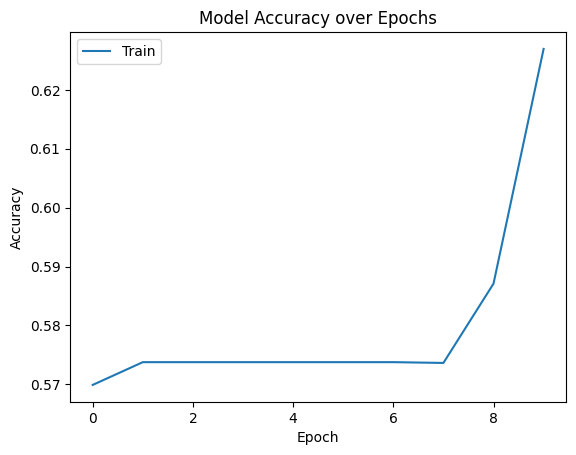

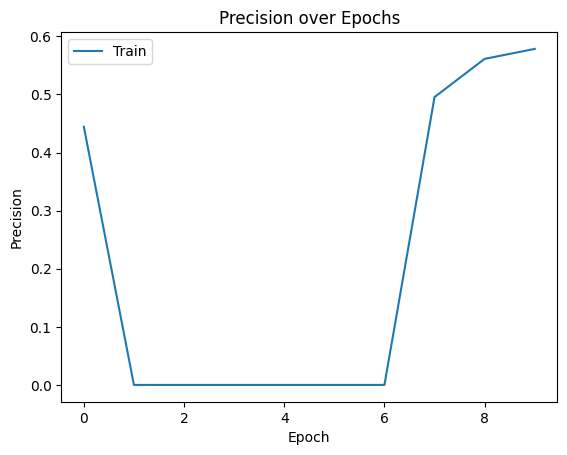

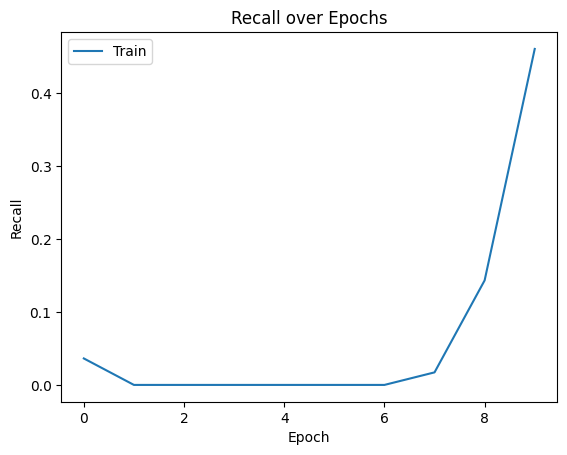

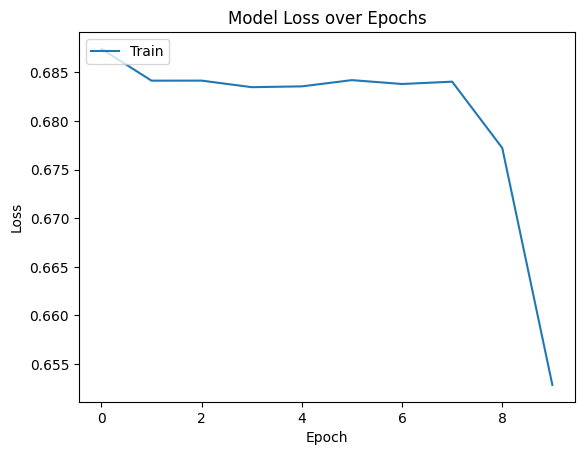

In [68]:
y_pred = model_predict(model_two_RNN, padded_sequences)
f1 = f1_score(train_labels, y_pred)
print(f'this is the final f1-score for the train set: {f1}')
plot_metrics_graph(history_two_RNN.history['accuracy'], 'Accuracy', 'Model Accuracy over Epochs')
plot_metrics_graph(history_two_RNN.history['precision'], 'Precision', 'Precision over Epochs')
plot_metrics_graph(history_two_RNN.history['recall'], 'Recall', 'Recall over Epochs')
plot_metrics_graph(history_two_RNN.history['loss'], 'Loss', 'Model Loss over Epochs')

In [69]:
y_pred = model_predict(model_two_RNN, padded_test_sequences)

102/102 [==============================] - 1s 11ms/step


In [70]:
submit_csv('two.csv', y_pred)

As can be seen, the F1-score was better in the two-layered RNN for the training set, but slightly worse in the test set with a 0.621 f1 score. What is very important information is to see that the two-layered RNN had a greater than 20% f1 score difference between testing and training f1-scores, meaning that it is overfitting. The highest precision and recall scores for training were past the 6th epoch, which means it is worth keeping the 10 epochs for every model. When fitting this model multiple times, the loss exploded upwards significantly in some runs. This means that the two-layered model had a problem, possibly related to exploding gradients. RNN's are susceptible to occurences of the vanishing/exploding gradient and they are characterized by a sudden spike in the loss.

Now, we will be testing an LSTM architecture instead of a RNN architecture. Since the two-layered RNN performed slightly worse than the one-layered RNN, the LSTM will be one layered because LSTM can retain more information due to the greatly increased complexity of its structure. The LSTM mitigates the issue of the exploding gradient, so the issue is not as prevalent in a LSTM layer compared to a standard RNN layer. The LSTM model will also have less neurons than the simple one layer RNN, to prevent overfitting.

In [71]:
def LSTM_model():
    model = Sequential([
                Embedding(input_dim=10000, output_dim=128, input_length=100),
                LSTM(units=32, return_sequences=False),  
                Dense(units=1, activation='sigmoid')
            ])
    
    return model

In [72]:
model_LSTM = LSTM_model()
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

history_LSTM = model_LSTM.fit(padded_sequences, train_labels, epochs=10)

Epoch 1/10
235/235 [==============================] - 13s 44ms/step - loss: 0.6835 - accuracy: 0.5732 - precision: 0.4688 - recall: 0.0094
Epoch 2/10
235/235 [==============================] - 10s 44ms/step - loss: 0.6832 - accuracy: 0.5738 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/10
235/235 [==============================] - 10s 43ms/step - loss: 0.6830 - accuracy: 0.5738 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/10
235/235 [==============================] - 10s 44ms/step - loss: 0.6826 - accuracy: 0.5738 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/10
235/235 [==============================] - 10s 44ms/step - loss: 0.6827 - accuracy: 0.5738 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/10
235/235 [==============================] - 10s 42ms/step - loss: 0.6821 - accuracy: 0.5738 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/10
235/235 [==============================] - 10s 42ms/step - loss: 0.6827 - accuracy: 0.5738 - precision: 0.0000e+00 

235/235 [==============================] - 3s 11ms/step
this is the final f1-score for the train set: 0.0


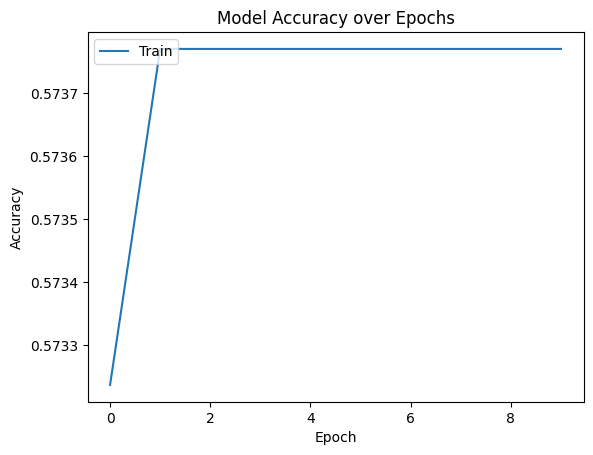

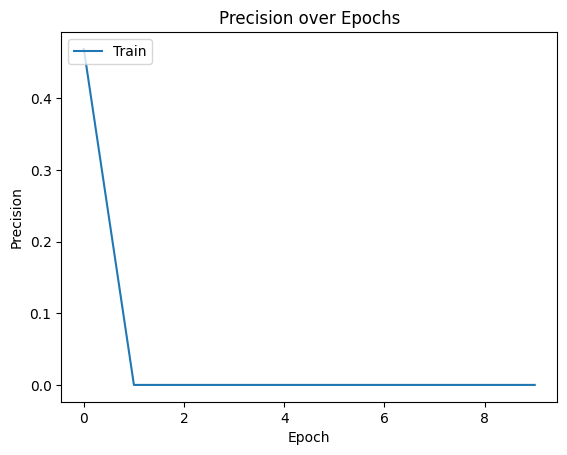

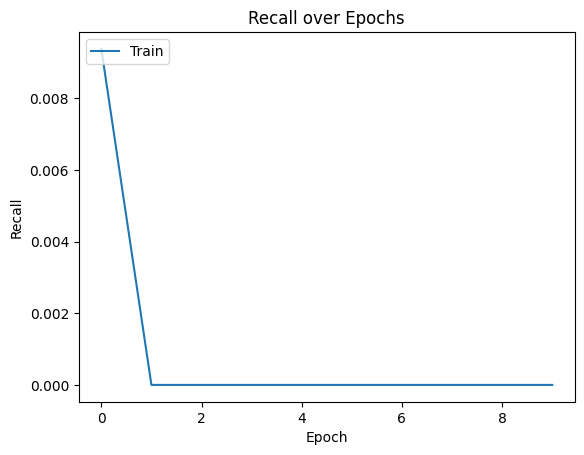

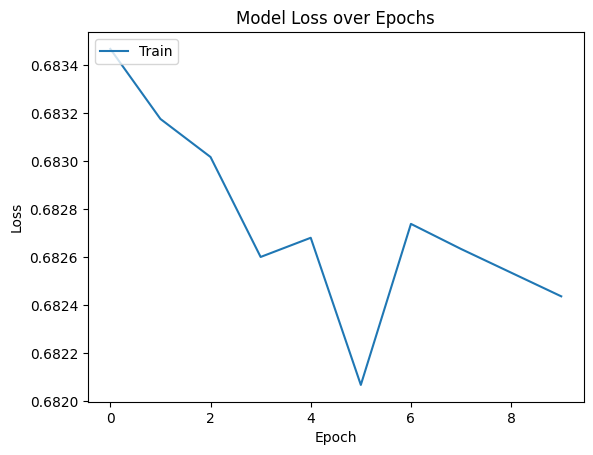

In [73]:
y_pred = model_predict(model_LSTM, padded_sequences)
f1 = f1_score(train_labels, y_pred)
print(f'this is the final f1-score for the train set: {f1}')
plot_metrics_graph(history_LSTM.history['accuracy'], 'Accuracy', 'Model Accuracy over Epochs')
plot_metrics_graph(history_LSTM.history['precision'], 'Precision', 'Precision over Epochs')
plot_metrics_graph(history_LSTM.history['recall'], 'Recall', 'Recall over Epochs')
plot_metrics_graph(history_LSTM.history['loss'], 'Loss', 'Model Loss over Epochs')

As can be seen above, the LSTM model is not learning and gets a 0 f1-score with a 57% accuracy, which almost corresponds to the length of labels in the majority class. This means that the LSTM model is probably only predicting the majority class. Simple RNN performs well on shorter sequences where long term knowledge is less important. In the simple RNN models, a maxlen of 100 was designated, meaning many sequences had large amounts of padding. LSTM is more sensitive to padding, since its strength of learning long term dependencies relies on gates that will be more busy handling the non-informative padding, losing important long term information that leads to worsening predictions. This time, I will reduce the padding significantly. The biggest sentence in the texts has a word count above 30, which means padding of 100 adds lots of zeroes as padding. This time, the maxlen will be 36, which means that most sequences will have only a little padding and LSTM can more effectively gain knowledge. 

In [74]:
## This snippet tokenizes the texts by creating a dictionary of a word to an numerical id. Then this is turned into a sequence of integers. The RNN structure only takes in a certain length sequence, so a length is set
## and anything that is shorter is padded with 0's while anything longer has the extra integers removed.
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_features) 

# Convert the text to sequences of integers
sequences = tokenizer.texts_to_sequences(train_features)
test_sequences = tokenizer.texts_to_sequences(test_features)

padded_sequences = pad_sequences(sequences, maxlen=36, padding='post')
padded_test_sequences = pad_sequences(test_sequences, maxlen=36, padding='post')

In [75]:
def LSTM_model():
    model = Sequential([
                Embedding(input_dim=10000, output_dim=128, input_length=36),
                LSTM(units=32, return_sequences=False),  
                Dense(units=1, activation='sigmoid')
            ])
    
    return model

In [76]:
model_LSTM = LSTM_model()
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

history_LSTM = model_LSTM.fit(padded_sequences, train_labels, epochs=10)

Epoch 1/10
235/235 [==============================] - 8s 25ms/step - loss: 0.5758 - accuracy: 0.6944 - precision: 0.7538 - recall: 0.4203
Epoch 2/10
235/235 [==============================] - 6s 25ms/step - loss: 0.3505 - accuracy: 0.8623 - precision: 0.8915 - recall: 0.7708
Epoch 3/10
235/235 [==============================] - 6s 26ms/step - loss: 0.2522 - accuracy: 0.9094 - precision: 0.9219 - recall: 0.8602
Epoch 4/10
235/235 [==============================] - 7s 29ms/step - loss: 0.1812 - accuracy: 0.9368 - precision: 0.9448 - recall: 0.9046
Epoch 5/10
235/235 [==============================] - 6s 27ms/step - loss: 0.1393 - accuracy: 0.9468 - precision: 0.9542 - recall: 0.9193
Epoch 6/10
235/235 [==============================] - 6s 27ms/step - loss: 0.1165 - accuracy: 0.9563 - precision: 0.9570 - recall: 0.9396
Epoch 7/10
235/235 [==============================] - 7s 29ms/step - loss: 0.0989 - accuracy: 0.9624 - precision: 0.9637 - recall: 0.9475
Epoch 8/10
235/235 [==============

235/235 [==============================] - 2s 7ms/step
this is the final f1-score: 0.9589540893888719


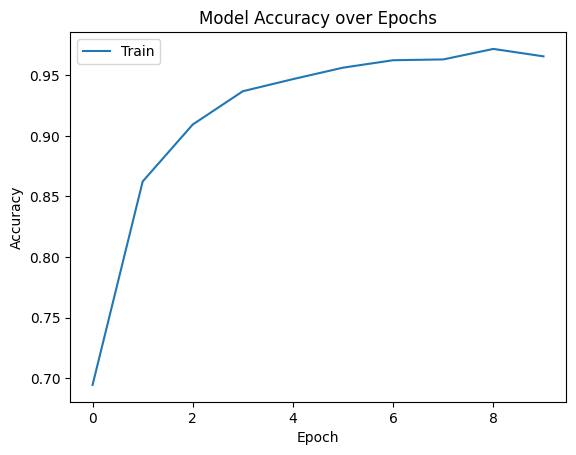

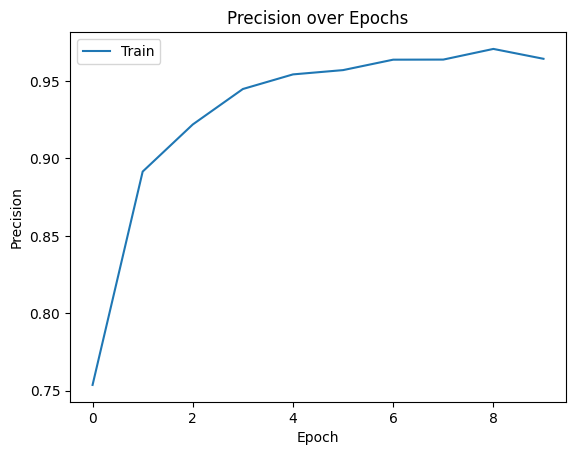

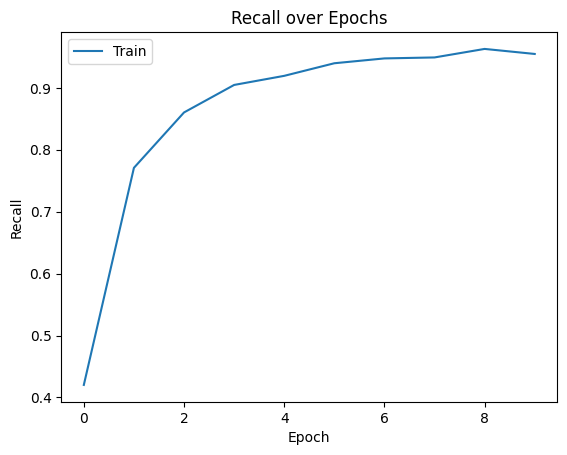

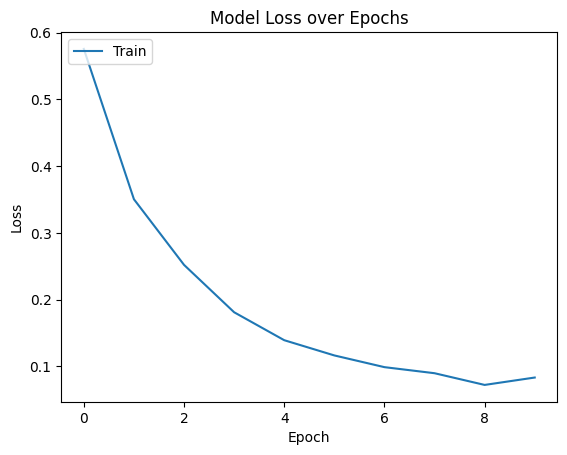

In [77]:
y_pred = model_predict(model_LSTM, padded_sequences)
f1 = f1_score(train_labels, y_pred)
print(f'this is the final f1-score: {f1}')
plot_metrics_graph(history_LSTM.history['accuracy'], 'Accuracy', 'Model Accuracy over Epochs')
plot_metrics_graph(history_LSTM.history['precision'], 'Precision', 'Precision over Epochs')
plot_metrics_graph(history_LSTM.history['recall'], 'Recall', 'Recall over Epochs')
plot_metrics_graph(history_LSTM.history['loss'], 'Loss', 'Model Loss over Epochs')

In [78]:
y_pred = model_predict(model_LSTM, padded_test_sequences)

102/102 [==============================] - 1s 7ms/step


In [79]:
submit_csv('LSTM_padding.csv', y_pred)

As can be seen, the padding optimization grew the LSTM f1-score from 0 to 97.4 on the train set. The test set f1-score also grew to 0.767, which means that there is overfitting but still better than the previous models seen. 

This means that the padding was the issue with the LSTM learning and also serves as a potential improvement to the simple RNN architecture models, since RNN's are only more resistant to the influence of padding, not immune. Typically, models using LSTM architecture take more epochs to converge to a good score. In this case, the 10 epochs is already enough to get a high f1-score so the epochs number wil stay the same

I will now test the old one layer RNN with the new padding, to see how much the new padding tuning affects the f1-score of the old one layer RNN model


In [80]:
def RNN_simple_reduced():
    model = Sequential([
                Embedding(input_dim=10000 , output_dim=128, input_length=36),
                SimpleRNN(units=64, return_sequences=False),
                Dense(units=1, activation='sigmoid')
            ])
    
    return model

In [81]:
model_simple_RNN_reduced = RNN_simple_reduced()
model_simple_RNN_reduced.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

history_simple_RNN_r = model_simple_RNN_reduced.fit(padded_sequences, train_labels, epochs=10)

Epoch 1/10
235/235 [==============================] - 7s 21ms/step - loss: 0.5457 - accuracy: 0.7377 - precision: 0.7468 - recall: 0.5819
Epoch 2/10
235/235 [==============================] - 5s 21ms/step - loss: 0.3592 - accuracy: 0.8601 - precision: 0.8782 - recall: 0.7799
Epoch 3/10
235/235 [==============================] - 5s 22ms/step - loss: 0.2242 - accuracy: 0.9186 - precision: 0.9316 - recall: 0.8730
Epoch 4/10
235/235 [==============================] - 5s 21ms/step - loss: 0.1207 - accuracy: 0.9580 - precision: 0.9616 - recall: 0.9390
Epoch 5/10
235/235 [==============================] - 5s 21ms/step - loss: 0.0769 - accuracy: 0.9727 - precision: 0.9728 - recall: 0.9628
Epoch 6/10
235/235 [==============================] - 5s 21ms/step - loss: 0.0660 - accuracy: 0.9768 - precision: 0.9764 - recall: 0.9690
Epoch 7/10
235/235 [==============================] - 5s 21ms/step - loss: 0.0543 - accuracy: 0.9803 - precision: 0.9799 - recall: 0.9737
Epoch 8/10
235/235 [==============

235/235 [==============================] - 1s 5ms/step
this is the final f1-score for the train set: 0.9848818897637795


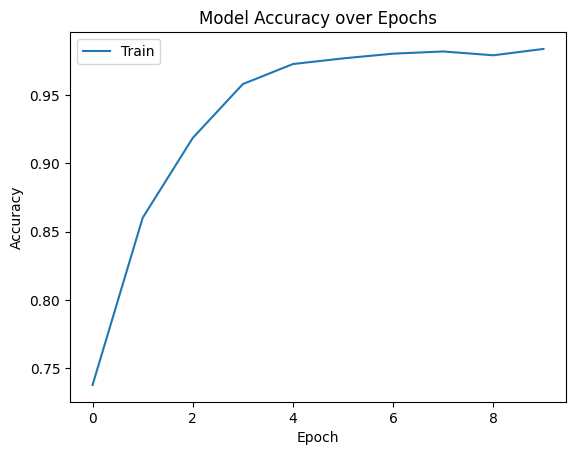

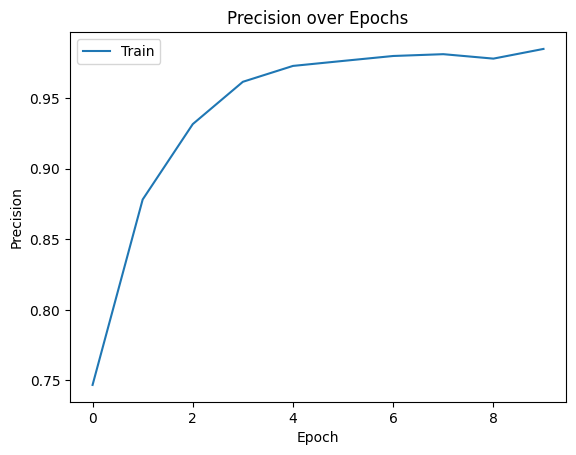

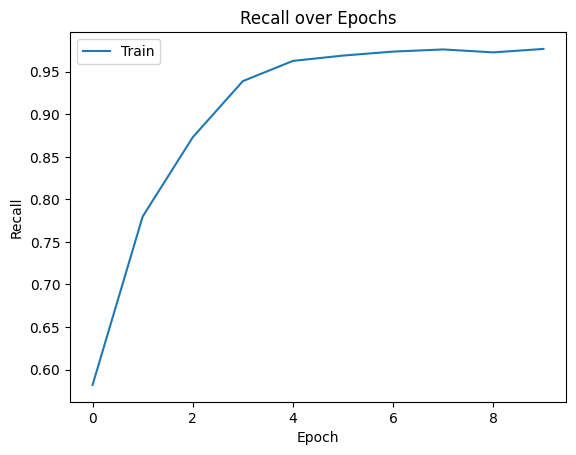

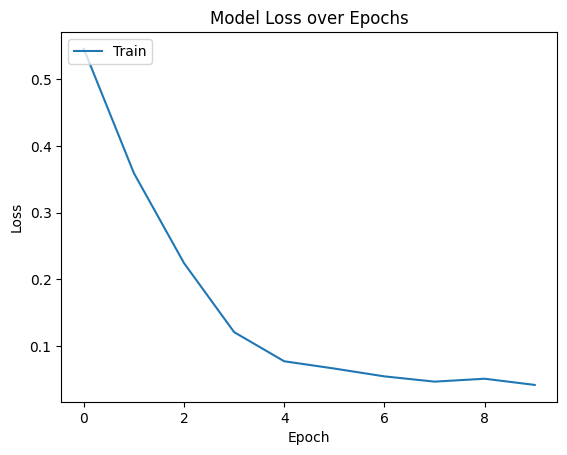

In [82]:
y_pred = model_predict(model_simple_RNN_reduced, padded_sequences)
f1 = f1_score(train_labels, y_pred)
print(f'this is the final f1-score for the train set: {f1}')
plot_metrics_graph(history_simple_RNN_r.history['accuracy'], 'Accuracy', 'Model Accuracy over Epochs')
plot_metrics_graph(history_simple_RNN_r.history['precision'], 'Precision', 'Precision over Epochs')
plot_metrics_graph(history_simple_RNN_r.history['recall'], 'Recall', 'Recall over Epochs')
plot_metrics_graph(history_simple_RNN_r.history['loss'], 'Loss', 'Model Loss over Epochs')

In [83]:
y_pred = model_predict(model_simple_RNN_reduced, padded_test_sequences)

102/102 [==============================] - 1s 5ms/step


In [84]:
submit_csv('RNN_padding.csv', y_pred)

As can be seen above, the padding tuning helped optimize the one layer RNN model too, allowing for a greater f1-score to be achieved. The train set f1-score was at 0.98 and the test set f1-score was at 0.744. While it was not better than the LSTM, it still performed well for not having the long term memory of LSTM architecture models. 

Next, we will try and see how well an LSTM and a RNN layer together can perform. This model will have a high risk of overfitting, due to it having two layers with large amounts of neurons, one of which is an LSTM. This model can capture long term dependencies with the LSTM layer and also provide robustness against vanishing gradients, while also being less resource intensive than two layers of LSTM.

In [85]:
def LSTM_two():
    model = Sequential([
                Embedding(input_dim=10000, output_dim=128, input_length=36),
                LSTM(units=32, return_sequences=True),  
                SimpleRNN(units=32, return_sequences=False),
                Dense(units=1, activation='sigmoid')
            ])
    
    return model

In [86]:
model_LSTM_two = LSTM_two()
model_LSTM_two.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

history_LSTM_two = model_LSTM_two.fit(padded_sequences, train_labels, epochs=10)

Epoch 1/10
235/235 [==============================] - 12s 34ms/step - loss: 0.5321 - accuracy: 0.7548 - precision: 0.7692 - recall: 0.6066
Epoch 2/10
235/235 [==============================] - 8s 35ms/step - loss: 0.3605 - accuracy: 0.8571 - precision: 0.8832 - recall: 0.7661
Epoch 3/10
235/235 [==============================] - 8s 35ms/step - loss: 0.2654 - accuracy: 0.9050 - precision: 0.9361 - recall: 0.8340
Epoch 4/10
235/235 [==============================] - 8s 34ms/step - loss: 0.2048 - accuracy: 0.9318 - precision: 0.9577 - recall: 0.8787
Epoch 5/10
235/235 [==============================] - 8s 33ms/step - loss: 0.1624 - accuracy: 0.9454 - precision: 0.9631 - recall: 0.9065
Epoch 6/10
235/235 [==============================] - 8s 34ms/step - loss: 0.1278 - accuracy: 0.9551 - precision: 0.9655 - recall: 0.9278
Epoch 7/10
235/235 [==============================] - 8s 35ms/step - loss: 0.1086 - accuracy: 0.9623 - precision: 0.9709 - recall: 0.9396
Epoch 8/10
235/235 [=============

235/235 [==============================] - 2s 8ms/step
this is the final f1-score: 0.9585163494387506


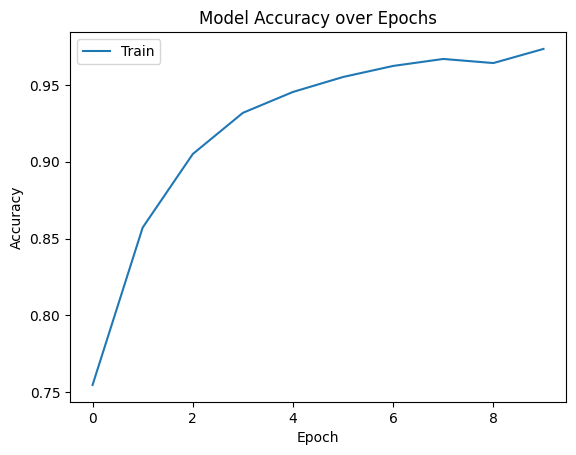

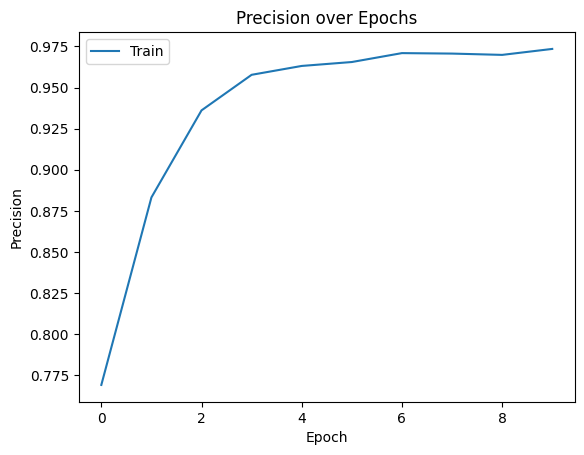

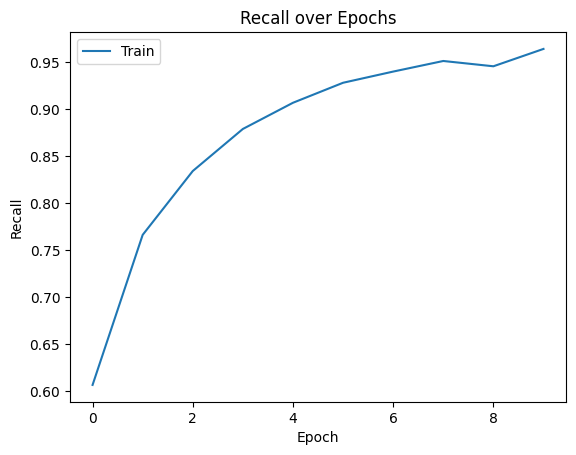

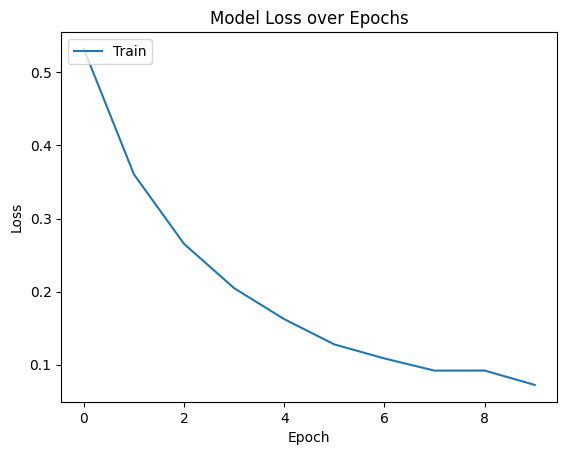

In [87]:
y_pred = model_predict(model_LSTM_two, padded_sequences)
f1 = f1_score(train_labels, y_pred)
print(f'this is the final f1-score: {f1}')
plot_metrics_graph(history_LSTM_two.history['accuracy'], 'Accuracy', 'Model Accuracy over Epochs')
plot_metrics_graph(history_LSTM_two.history['precision'], 'Precision', 'Precision over Epochs')
plot_metrics_graph(history_LSTM_two.history['recall'], 'Recall', 'Recall over Epochs')
plot_metrics_graph(history_LSTM_two.history['loss'], 'Loss', 'Model Loss over Epochs')

In [88]:
y_pred = model_predict(model_LSTM_two, padded_test_sequences)

102/102 [==============================] - 1s 8ms/step


In [89]:
submit_csv('LSTM_RNN_comb.csv', y_pred)

The LSTM and simpleRNN model tied in the test set with the single LSTM with padding model, gaining a 0.76 test set f1-score. This result makes sense, since the problem with the previous models was overfitting of the model, with high training f1-scores and lower test f1-scores. This model did not address these deficiencies, since it still had two layers with a high amount of neurons in each layer.

                                                                                            **CONCLUSION**

| Model | Training f1      | Test f1 |
|----|-----------|-----|
| Simple  | 0.79     | 0.65  |
| Two layer RNN  | 0.93      | 0.62  |
| LSTM, pre-padding change | 0.0   | 0  |
| LSTM, post padding change |0.97 | 0.76  |
| Simple post padding | 0.98 | 0.74 |
| LSTM and simpleRNN combined | 0.97 | 0.76  |

As can be seen in the table above, the best model was the one layer LSTM after the padding change. It had the highest test f1-score at 0.76. It seems that the slightly more complex architectures, the ones with LSTM layers, did better than the other models slightly. This is probably due to their longer memory. It did not do much better though and seems to be overfitting, which means techniques like early stopping would be necessary, perhaps reducing neurons in the layers slightly would also increase the generalization of the model.

Overall the biggest lesson learned was to pre-process the dataset well because I had not put thought into the padding and the padding was what was bringing down the test accuracy in all the models. The big improvements came from changing the padding, with the bad padding only being visible due to how bad the first LSTM model performed. 

Making the architecture a little more complex did help increase the f1-score very slightly, since the LSTM models had the best f1-scores by 2%. There was overfitting of the data since the training set f1-scores were much higher than the test f1-scores. To resolve this in the future, I should add validation sets and then implement early stopping whenever the validation scores lower in an epoch. This would help with stopping overfitting if it happens in the later epochs, and the validation set would also help spot the overfitting sooner rather than being surprised during the submission of the testing data. Trying other architectures like bi-directional RNN's might increase f1-scores too, so it is something to do for next time.

This link helped explain f1-score to me:
https://www.v7labs.com/blog/f1-score-guide